Shape of training dataset: (60000, 28, 28)
Shape of test dataset: (10000, 28, 28)
Label for image: 5


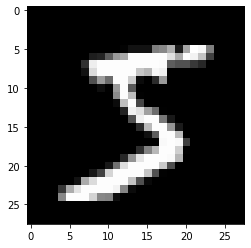

In [1]:
#Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py
import cv2

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

#Setting the random seed so that the results are reproducible. 
random.seed(101)

#Setting variables for MNIST image dimensions
mnist_image_height = 28
mnist_image_width = 28

#Import MNIST data from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Checking the downloaded data
print("Shape of training dataset: {}".format(np.shape(X_train)))
print("Shape of test dataset: {}".format(np.shape(X_test)))


plt.figure()
plt.imshow(X_train[0], cmap='gray')

print("Label for image: {}".format(y_train[0]))

(4, 4, 6, 8, 0)

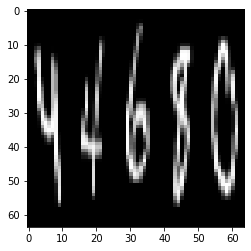

In [2]:
def build_synth_data(data,labels,dataset_size):
    
    #Define synthetic image dimensions
    synth_img_height = 64
    synth_img_width = 64
    
    #Define synthetic data
    synth_data = np.ndarray(shape=(dataset_size,synth_img_height,synth_img_width),
                           dtype=np.float32)
    
    #Define synthetic labels
    synth_labels = [] 
    
    #For a loop till the size of the synthetic dataset
    for i in range(0,dataset_size):
        
        #Pick a random number of digits to be in the dataset
        num_digits = random.randint(1,5)
        
        #Randomly sampling indices to extract digits + labels afterwards
        s_indices = [random.randint(0,len(data)-1) for p in range(0,num_digits)]
        
        #stitch images together
        new_image = np.hstack([X_train[index] for index in s_indices])
        #stitch the labels together
        new_label =  [y_train[index] for index in s_indices]
        
        
        #Loop till number of digits - 5, to concatenate blanks images, and blank labels together
        for j in range(0,5-num_digits):
            new_image = np.hstack([new_image,np.zeros(shape=(mnist_image_height,
                                                                   mnist_image_width))])
            new_label.append(10) #Might need to remove this step
        
        #Resize image
        #new_image = misc.imresize(new_image,(64,64))
        new_image = cv2.resize(new_image,(64,64))
        
        #Assign the image to synth_data
        synth_data[i,:,:] = new_image
        
        #Assign the label to synth_data
        synth_labels.append(tuple(new_label))
        
    
    #Return the synthetic dataset
    return synth_data,synth_labels

#Building the training dataset
X_synth_train,y_synth_train = build_synth_data(X_train,y_train,60000)

#Building the test dataset
X_synth_test,y_synth_test = build_synth_data(X_test,y_test,10000)

#checking a sample
plt.figure()
plt.imshow(X_synth_train[0], cmap='gray')

y_synth_train[0]

In [8]:
#Converting labels to One-hot representations of shape (set_size,digits,classes)
possible_classes = 11

def convert_labels(labels):
    
    #As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    #Each digit array will be of shape (60000,11)
    
    #Code below could be better, but cba for now. 
    
    #Declare output ndarrays
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes)) #5 for digits, 11 for possible classes  
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        #Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

train_labels = convert_labels(y_synth_train)
test_labels = convert_labels(y_synth_test)

#Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(60000, 11)

In [9]:
def prep_data_keras(img_data):
    
    #Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data),64,64,1)
    
    #Converting everything to floats
    img_data = img_data.astype('float32')
    
    #Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data

train_images = prep_data_keras(X_synth_train)
test_images = prep_data_keras(X_synth_test)

np.shape(train_images)

(60000, 64, 64, 1)

In [10]:

#Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

#Building the model

batch_size = 128
nb_classes = 11
nb_epoch = 12

#image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

#number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

#defining the input
inputs = Input(shape=(img_rows,img_cols,img_channels))

#Model taken from keras example. Worked well for a digit, dunno for multiple
#cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1],border_mode='same')(inputs)
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1])(inputs)
cov = Activation('relu')(cov)
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1])(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)


#Dense Layers
cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)



#Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

#Defining the model
model = Model(inputs=inputs, outputs=[c0,c1,c2,c3,c4])

#Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size, epochs=nb_epoch,verbose=1,
          validation_data=(test_images, test_labels) )

2022-08-29 19:51:42.684499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/12
469/469 [==============================] - 16s 31ms/step - loss: 6.8061 - dense_1_loss: 1.8181 - dense_2_loss: 1.7596 - dense_3_loss: 1.3828 - dense_4_loss: 0.9795 - dense_5_loss: 0.8662 - dense_1_accuracy: 0.3426 - dense_2_accuracy: 0.3794 - dense_3_accuracy: 0.5329 - dense_4_accuracy: 0.6741 - dense_5_accuracy: 0.7962 - val_loss: 4.3738 - val_dense_1_loss: 0.9863 - val_dense_2_loss: 1.1406 - val_dense_3_loss: 0.8634 - val_dense_4_loss: 0.6264 - val_dense_5_loss: 0.7571 - val_dense_1_accuracy: 0.7346 - val_dense_2_accuracy: 0.6753 - val_dense_3_accuracy: 0.7613 - val_dense_4_accuracy: 0.8162 - val_dense_5_accuracy: 0.8005
Epoch 2/12
469/469 [==============================] - 17s 35ms/step - loss: 4.8123 - dense_1_loss: 1.1825 - dense_2_loss: 1.2193 - dense_3_loss: 0.9341 - dense_4_loss: 0.6907 - dense_5_loss: 0.7856 - dense_1_accuracy: 0.5847 - dense_2_accuracy: 0.5735 - dense_3_accuracy: 0.6735 - dense_4_accuracy: 0.7591 - dense_5_accuracy: 0.8024 - val_loss: 3.2261 - val_

(64, 64)
1/1 [==============================] - 0s 33ms/step
Digit 1 is:  1
Digit 2 is:  3
Digit 3 is:  7
Digit 4 is:  1
Digit 5 is: _


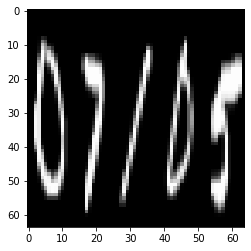

In [22]:
# Load training sample
imageTrain = X_synth_train[1]
print(imageTrain.shape)
# Plot the input image 
plt.imshow(imageTrain, cmap='gray')

# Predict taining sample
imageTrain = imageTrain.reshape((1,64,64,1))
prediction = model.predict(imageTrain)

# Plot results 
for i in range(0, 5): 
    digitResult = np.argmax(prediction[i])
    if digitResult == 10:
        print("Digit", i+1, "is: _")
    else: 
        print("Digit", i+1, "is: ", digitResult+1)

1/1 [==============================] - 0s 158ms/step


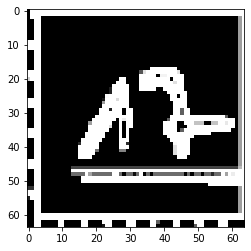

In [11]:
# Predict arbitrary sample

# Load the image and convert to grayscale 
image = cv2.imread('testImages/multiDigitSample.jpg')

# Grayscale the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply THRESHOLDING in order to invert the color space
# 

# Canny image (because the MNIST data samples are "inverted" in color space)
image = cv2.Canny(image, 100, 200)

# Dilate the canny image in order to get more dense digits
kernel = np.ones((5,5),np.uint8)
image = cv2.dilate(image, kernel, iterations = 3)

# Resize the image 
image = cv2.resize(image, (64,64))

# Normalize the image
image = image.astype('float32')
image /= 255

# Plot the input image 
plt.imshow(image, cmap='gray')

# Use (MNIST trained) model in order to predict the number
image = image.reshape((1,64,64,1))
prediction = model.predict(image)

# Plot results 
for i in range(0, 5): 
    digitResult = np.argmax(prediction[i])
    if digitResult == 10:
        print("Digit", i+1, "is: _")
    else: 
        print("Digit", i+1, "is: ", digitResult+1)
    